# QuantumSim - Quantum Approximation Optimization Algorithm (QAOA) - Noisy
Author: Nico Kuijpers<br>
Date: May 29, 2025

The Quantum Approximation Optimization Algorithm (QAOA) is an example of a Variational Quantum Algorithm (VQA).
QAOA can be applied to find approximate solutions to combinatorial optimization problems.

In this notebook, we introduce the Maximum Cut (or Max-Cut) problem and we show how QAOA can be implemented in 
QuantumSim to find an approximate solution for the Max-Cut problem.

The description of the Max-Cut problem and QAOA in this notebook is adapted from Chapter 12 of:<br>
Robert S. Sutor, 
Dancing with Qubits: From qubits to algorithms, embark on the quantum computing journey shaping our future,
second edition, Packt Publishing, Birmingham, UK, ISBN 978-1-83763-675-4

Reference to QAOA:<br>
Edward Farhi, Jeffrey Goldstone, and Sam Gutmann. 
A Quantum Approximate Optimization Algorithm. 
arXiv:1411.4028, November 2014.
https://arxiv.org/pdf/1411.4028

Qiskit tutorials to implement QAOA in Qiskit:<br>
https://qiskit-community.github.io/qiskit-algorithms/tutorials/05_qaoa.html

https://qiskit-rigetti.readthedocs.io/en/v0.4.1/examples/qaoa_qiskit.html

In this notebook we use QuantumSim.

In [ ]:
from quantumsim.quantumsim import *

# Introduction


Combinatorial optimization problems are mathematical problems for which the objective is to find a solution with minimum cost. 
Finding an optimal solution usually requires a search through all possible solutions. For these problems, the search space grows
exponentially (or worse) with the problem size. To ensure that a solution of minimum cost will be found, the entire search space has to 
be traversed.

A well-known example of a combinatorial optimization problem is the Traveling Salesman Problem (TSP). 
In TSP, the salesman has to visit a number of cities exactly once and return to the starting city. 
An optimal solution to the TSP is defined as the shortest route that starts and ends at the same city and visits each city exactly once.
To be sure that an optimal solution is found, every possible route has to be tried. For $N$ cities, the number of possible routes is $(N-1)!$. 
For $10$ cities, the number of possible routes is $10! = 3628800$. For $15$ cities, it is $15!= 1307674368000$.

Finding an optimal solution for TSP by computing the length of each possible route is called a *brute force* approach.
Such approach is not feasible on classical computers for a larger number of cities (for example $N \geq 20$). 
Therefore, optimization problems such as TSP are usually solved using *heuristic algorithms* or *approximation algorithms*.

Another example of a combinatorial optimization problem is the Maximum Cut or Max-Cut problem. In this notebook, we introduce the Max-Cut
problem and find solutions using a brute-force approach, a heuristic approach (simulated annealing), and using QAOA.

# Max-cut problem
Let $\mathbf{G}(\mathbf{N},\mathbf{E})$ be a graph with nodes $\mathbf{N}$ and edges $\mathbf{E}$.
Let $\mathbf{U}$ be a proper nonempty subset of $\mathbf{N}$. 
This means $\mathbf{U}$ has at least one element of $\mathbf{N}$, but not all. 
$\mathbf{U}'$ is the *complement* of $\mathbf{U}$, i.e., it contains all elements of $\mathbf{N}$ 
that are not in $\mathbf{U}$. Thus, both $\mathbf{U}$ and $\mathbf{U}'$ are not empty.

We define $\delta(\mathbf{U})$ as the set of all edges $u u' \in \mathbf{E}$ 
for which $u \in \mathbf{U}$ and $u' \in \mathbf{U}'$. 
$\delta(\mathbf{U})$ is called a *cut* of graph $\mathbf{G}(\mathbf{N},\mathbf{E})$. The size of $\delta(\mathbf{U})$ is
denoted by $|\delta(\mathbf{U})|$. It is the number of edges that connect nodes in $\mathbf{U}$ with nodes in $\mathbf{U}'$.

The *Maximum Cut Problem* or *Max-Cut Problem* for graph $\mathbf{G}(\mathbf{N},\mathbf{E})$ is to find a proper nonempty subset $\mathbf{U}$ of $\mathbf{N}$ such that $|\delta(\mathbf{U})|$ is as large as possible. Note that $\mathbf{U}$ does
not have to be unique. We call a $\mathbf{U}$ with maximum $|\delta(\mathbf{U})|$ a *maximum cut*.

The Max-Cut problem is an optimization problem. The goal is to maximize $|\delta(\mathbf{U})|$.

### Example
Below a graph $\mathbf{G}(\mathbf{N},\mathbf{E})$ is defined with $4$ nodes and $8$ edges. 
The graph is defined and displayed using *NetworkX*, which is a Python package for complex networks.
It has functionality for the creation and visualisation of graphs.

See https://networkx.org/


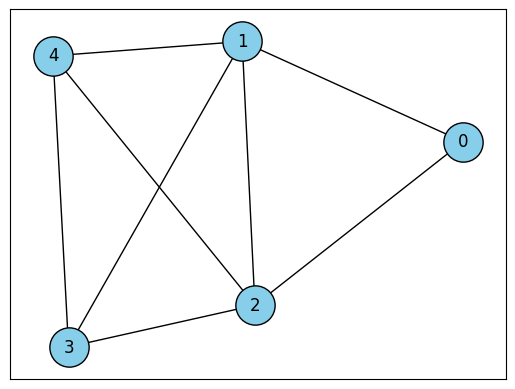

In [2]:
import networkx as nx

# Define nodes and edges
nodes = [0, 1, 2, 3, 4]
edges = [(0,1), (0,2), (1,2), (1,3), (2,3), (1,4), (2,4), (3,4)]

# Construct the graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Layout to draw the graph
pos = nx.spring_layout(G, seed=42)

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800, edgecolors='black')
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos)


Let's divide the nodes of $\mathbf{G}(\mathbf{N},\mathbf{E})$ in $\mathbf{U}$ and $\mathbf{U}'$.
$\mathbf{U}$ contains nodes $0$ and $2$. $\mathbf{U}'$ contains nodes $1$ and $3$.

We call this a *partition*. Below, a dictionary of key-value pairs is defined to represent this partition. 
All nodes are keys and values are either $0$ or $1$. 
For node $n \in \mathbf{N}$ value $0$ means $n \in \mathbf{U}$ and value $1$ means $n \in \mathbf{U}'$.

In [3]:
partition = {0:0, 1:1, 2:0, 3:1, 4:0}

Below Python function `show_graph` is defined to draw a graph showing the nodes in $\mathbf{U}$ in blue and the nodes in $\mathbf{U}'$ in green. Edges $u u' \in \delta(\mathbf{U})$ are shown in red.

In [4]:
import networkx as nx

def show_graph_partition(nodes, edges, partition):
    """
    Show graph partition

    Parameters:
    nodes        : list of nodes 
    edges        : list of edges
    partition    : graph partition
    """

    # Construct the graph
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    # Layout to draw the graph
    pos = nx.spring_layout(G, seed=42)

    # Colors for the nodes
    colors = ['skyblue' if partition[node] == 0 else 'lightgreen' for node in G.nodes()]

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=800, edgecolors='black')
    nx.draw_networkx_labels(G, pos)

    # Divide the edges between `cut` edges and `same` edges
    cut_edges = [(u, v) for u, v in G.edges() if partition[u] != partition[v]]
    same_edges = [(u, v) for u, v in G.edges() if partition[u] == partition[v]]

    # Draw edges
    nx.draw_networkx_edges(G, pos, edgelist=same_edges, width=1.5, style='solid', edge_color='black')
    nx.draw_networkx_edges(G, pos, edgelist=cut_edges, width=2.5, style='dashed', edge_color='red')

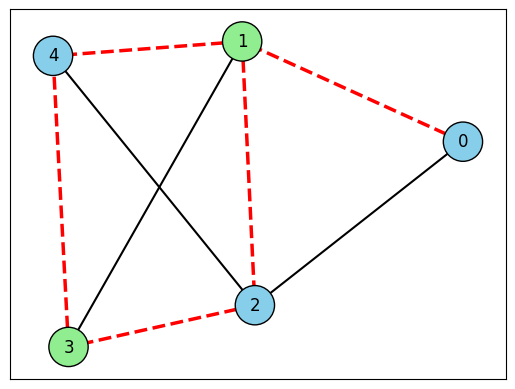

In [5]:
show_graph_partition(nodes, edges, partition)

For a given partition $\mathbf{U}$ and $\mathbf{U}'$, the number of edges in the cut, $|\delta(\mathbf{U})|$, can
be computed by function `cut_size` defined below.

In [6]:
def cut_size(edges, partition):
    return sum(1 for u, v in edges if partition[u] != partition[v])

For the example given above, the cut size can be determined:

In [7]:

print(f"Partition: {partition}")
print(f"Cut size for this partition: {cut_size(edges, partition)}")

Partition: {0: 0, 1: 1, 2: 0, 3: 1, 4: 0}
Cut size for this partition: 5


## QAOA circuit
Let $N = |\mathbf{N}|$ be the number of nodes. 
We define bit string $x = x_0 x_1 \ldots x_{N-1}$ of length $N$ as follows:

$x_n = 
\begin{cases}
0 & \text{if } n \in \mathbf{U} \\
1 & \text{if } n \in \mathbf{U}'
\end{cases}
$

Below, a python function is defined to create a QAOA circuit of $N$ qubits for given $\gamma$, $\beta$, and graph $\mathbf{G}(\mathbf{N},\mathbf{E})$.

Executing and measuring this circuit multiple times results in a distribution of possible solutions. The most occurring solutions represent
partitions with high max-cut size.

For a more detailed explanation of QAOA and the role of $\gamma$ and $\beta$, see the references at the beginning of this notebook.

REMARK: We have added parameter *noise_factor* to indicate the amount of noise.

REMARK: Note that both $\beta$ and $\gamma$ are mulitplied with factor 2. Note that Michel used IsingZZ, whereas we use CNOT, Z, CNOT.

In [8]:
# Create the QAOA circuit
def qaoa_circuit(gamma:list[float], beta:list[float], nodes:list, edges:list, p:int, noise_factor:float) -> Circuit:
    """
    Creates a quantum circuit of p layers for the Quantum Approximate Optimiziation Algorithm

    Parameters:
    gamma        : list of length p containing values for gamma, 0 < gamma < pi
    beta         : list of length p containing values for beta, 0 < beta < pi
    nodes        : list of nodes 
    edges        : list of edges
    p            : number of layers
    noise_factor : indicate amount of noise

    Returns:
    QAOA circuit with p layers
    """

    # Consistency check
    if len(gamma) != p or len(beta) != p:
        raise ValueError(f"Lists gamma and beta should be of length p = {p}")
    
    # Create circuit witn n qubits, where n is the number of nodes
    n = len(nodes)
    circuit = Circuit(n, save_instructions=True, noise_factor=noise_factor)
    
    # Initialize circuit by applying the Hadamard gate to all qubits
    for q in range(n):
        #circuit.hadamard(q)
        circuit.noisy_hadamard(q)

    # Construct p alternating cost and mixer layers
    for i in range(p):
    
        # Construct cost layer with parameter gamma[i]
        for edge in edges:
            #circuit.cnot(edge[0], edge[1])
            circuit.noisy_cnot(edge[0], edge[1])
            #circuit.rotate_z(2 * gamma[i], edge[1])
            circuit.noisy_rotate_z(2 * gamma[i], edge[1])
            #circuit.cnot(edge[0], edge[1])
            circuit.noisy_cnot(edge[0], edge[1])
        
        # Construct mixer layer with parameter beta[i]
        for q in range(n):
            #circuit.rotate_x(2 * beta[i], q)
            circuit.noisy_rotate_x(2 * beta[i], q)
    
    #return circuit
    return circuit

Create and execute a circuit with one cost layer and one mixer layer with $\gamma = \pi/8$ and $\beta = \pi/3$.

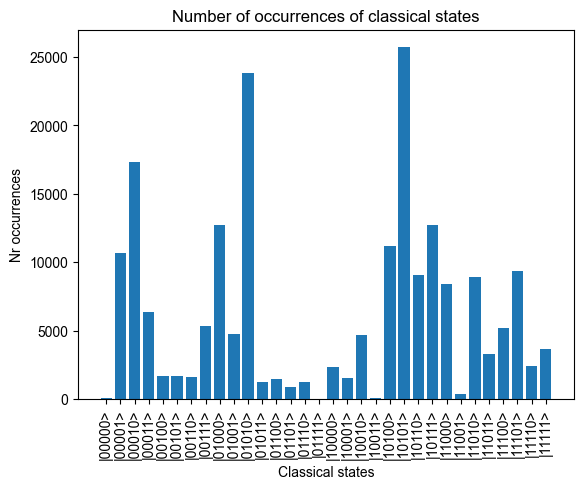

In [10]:
gamma = [np.pi/8]
beta = [np.pi/3]
nr_measurements = 200000
circuit = qaoa_circuit(gamma, beta, nodes, edges, 1, noise_factor=0.01)
result = QuantumUtil.measure_circuit(circuit, nr_measurements=nr_measurements)
QuantumUtil.histogram_of_classical_states(result)

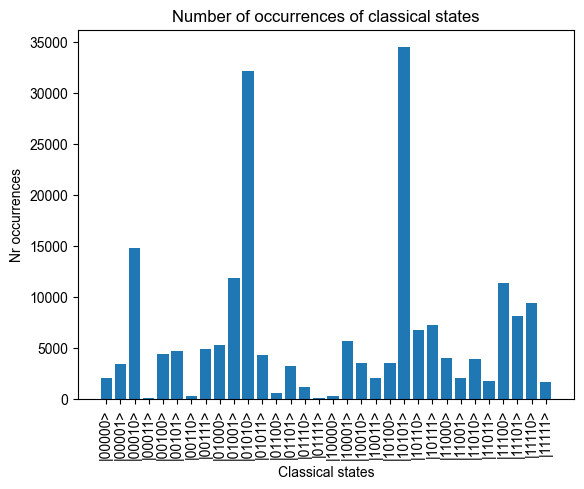

In [11]:
gamma = [np.pi/8]
beta = [np.pi/3]
nr_measurements = 200000
circuit = qaoa_circuit(gamma, beta, nodes, edges, 1, noise_factor=0.1)
result = QuantumUtil.measure_circuit(circuit, nr_measurements=nr_measurements)
QuantumUtil.histogram_of_classical_states(result)

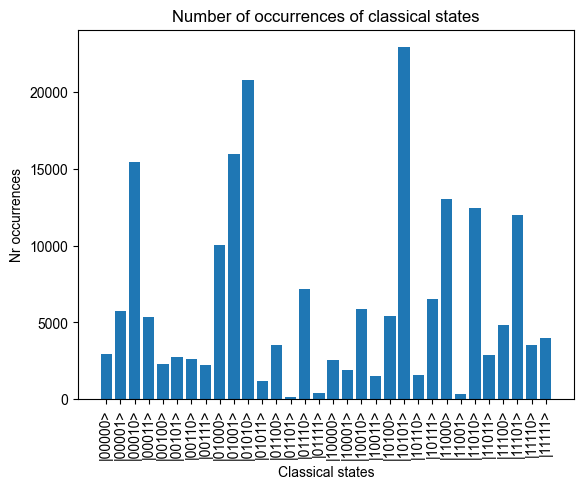

In [12]:
gamma = [np.pi/8]
beta = [np.pi/3]
nr_measurements = 200000
circuit = qaoa_circuit(gamma, beta, nodes, edges, 1, noise_factor=1)
result = QuantumUtil.measure_circuit(circuit, nr_measurements=nr_measurements)
QuantumUtil.histogram_of_classical_states(result)

Below, a function is defined to obtain the partition from the most occurring measurement.

In [13]:
def compute_partition(nodes:list, edges:list, result:list) -> dict:
    """
    Compute partition from the most occurring measurement

    Parameters:
    nodes  : list of nodes
    edges  : list of edges
    result : list of strings containing measurements

    Returns:
    Partition corresponding to most occurring result
    """

    # Count occurrences of each string in result
    counter = Counter(result)

    # Get the most occurring string from result
    most_common_string = counter.most_common(1)[0][0]

    # Determine partition corresponding to the most occurring string
    bit_string = most_common_string[1:-1]
    partition = {node: 0 if bit_string[node] == '0' else 1 for node in nodes}

    # Return partition corresponding to the most occurrring string in result
    return partition

Use this function of determine the partition, compute its cut size and show the partition.

Partition {0: 1, 1: 0, 2: 1, 3: 0, 4: 1} has cut size 5


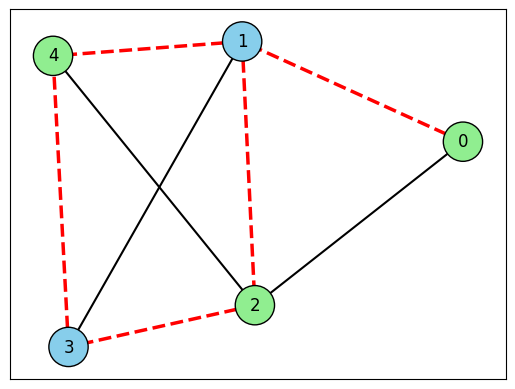

In [14]:
partition = compute_partition(nodes, edges, result)
partition_cut_size = cut_size(edges, partition)
print(f"Partition {partition} has cut size {partition_cut_size}")

show_graph_partition(nodes, edges, partition)

In [28]:
def plot_probability_distribution_noise(state_vectors):
    """
    Create a bar plot showing average and standard deviation of 
    probabilities of occurrences of classical states.

    Parameters:
    state_vectors : list of state vectors. 
    
    A state vector is an array of 2^N complex numbers representing the quantum state of a circuit of size N
    """

    # Determine the number of qubits
    nr_qubits = int(np.log2(len(state_vectors[0])))

    # Determine the probabilities
    probalities = np.square(np.abs(state_vectors))
    
    # For a noisy circuit, the sum of probabilities may not be equal to one
    probalities = [prob / np.sum(prob) for prob in probalities]

    # Compute mean and standard deviation for each index
    mean_probalities = np.mean(probalities, axis=0).flatten()
    std_probabilities = np.std(probalities, axis=0).flatten()

    # Create the labels for the x-axis
    labels = [Dirac.state_as_string(i, nr_qubits) for i in range(2**nr_qubits)]

    # Show the distribution of probabilities using a bar plot
    plt.bar(labels, mean_probalities, yerr=std_probabilities, capsize=3)
    if nr_qubits > 3:
        plt.xticks(rotation='vertical')
    plt.xlabel('Classical states')
    plt.ylabel('Probability')
    plt.title('Mean and standard deviation of probabilities')

In [29]:
def execute_circuit(circuit:Circuit, nr_executions=100):
    result = []
    for i in range(nr_executions):
        circuit.execute()
        result.append(circuit.state_vector.get_quantum_state())
    return result

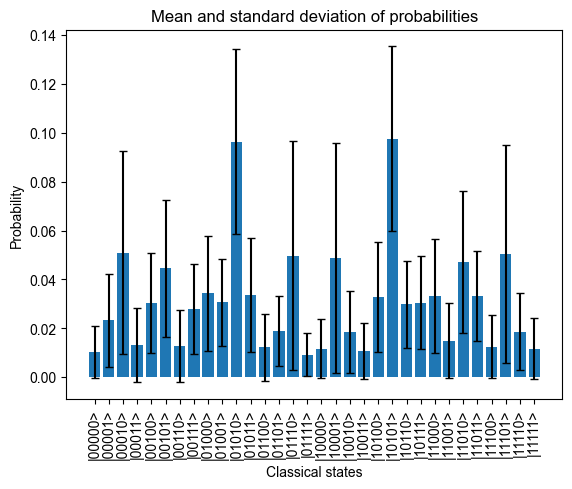

In [30]:
gamma = [np.pi/8]
beta = [np.pi/3]
circuit = qaoa_circuit(gamma, beta, nodes, edges, 1, noise_factor=0.001)
result = QuantumUtil.measure_circuit(circuit, nr_measurements=nr_measurements)
state_vectors = execute_circuit(circuit, 100)
plot_probability_distribution_noise(state_vectors)

## Compute average cut size from probabilities

In [18]:
def compute_average_cut_size_from_probabities(nodes:list, edges:list, state_vectors:list) -> float:
    """
    Compute average cut size from list of state vectors for noisy QAOA circuits.

    Parameters:
    nodes         : list of nodes
    edges         : list of edges
    state_vectors : list of state vectors

    Returns:
    average cut size
    """
    # Determine the number of qubits
    nr_qubits = int(np.log2(len(state_vectors[0])))

    # Determine the probabilities
    probalities = np.square(np.abs(state_vectors))
    
    # For a noisy circuit, the sum of probabilities may not be equal to one
    probalities = [prob / np.sum(prob) for prob in probalities]

    # Compute mean and standard deviation for each index
    mean_probalities = np.mean(probalities, axis=0).flatten()

    # Compute average cut size from probabilities
    sum_cut_size = 0
    for i in range(2**nr_qubits):
        string = Dirac.state_as_string(i, nr_qubits)
        bit_string = string[1:-1]
        partition = {node: bit_string[node] for node in nodes}
        partition_cut_size = cut_size(edges, partition)
        sum_cut_size += partition_cut_size*mean_probalities[i]

    average_cut_size = sum_cut_size/np.sum(mean_probalities)
    return average_cut_size

Below, the QAOA algorithm is part of a classical algorithm to find optimal values of $\gamma$ and $\beta$. 
As cost function, the negative value of the average cut size is used.
Here, the COBYLA algorithm is used to minimize the cost function.

COBYLA is short for Constrained Optimization BY Linear Approximation and is provided by SciPy.

See: https://docs.scipy.org/doc/scipy/reference/optimize.minimize-cobyla.html

In [19]:
from scipy.optimize import minimize

def optimization(parameters):
    gamma, beta = parameters
    circuit = qaoa_circuit([gamma], [beta], nodes, edges, p=1, noise_factor=0.001)
    state_vectors = execute_circuit(circuit, nr_executions=100)
    average_cut_size = compute_average_cut_size_from_probabities(nodes, edges, state_vectors)
    return -average_cut_size

res = minimize(optimization, [np.pi/2, np.pi/2], method='COBYLA')
print(res)

gamma = res.x[0]
beta = res.x[1]
print(f"gamma = {gamma}")
print(f"beta = {beta}")

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -4.344857850732589
       x: [ 2.833e+00  2.426e+00]
    nfev: 27
   maxcv: 0.0
gamma = 2.8334080755029754
beta = 2.4259533010693546


Now we create a noisy QAOA circuit with one layer and optimal parameters $\gamma$ and $\beta$.

Average cut size 4.348357717708924 for gamma = 2.8334080755029754 and beta = 2.4259533010693546


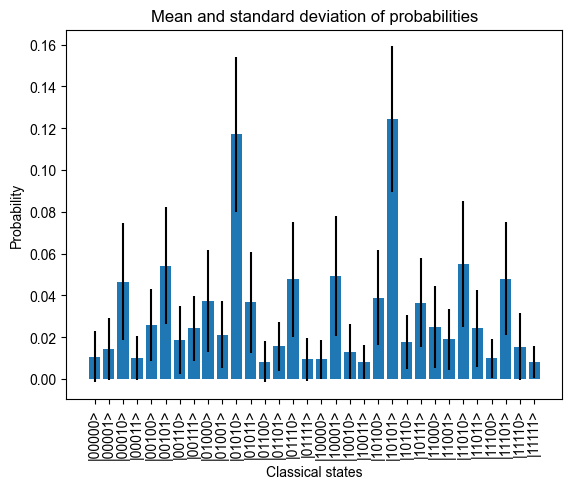

In [20]:
circuit = qaoa_circuit([gamma], [beta], nodes, edges, 1, noise_factor=0.001)
state_vectors = execute_circuit(circuit, 100)
plot_probability_distribution_noise(state_vectors)
average_cut_size = compute_average_cut_size_from_probabities(nodes, edges, state_vectors)
print(f"Average cut size {average_cut_size} for gamma = {gamma} and beta = {beta}")

Below, a function is defined to obtain the partition correspondng the classical state with maximum probability.

In [21]:
def compute_partition_from_probabilities(nodes:list, edges:list, state_vectors:list) -> dict:
    """
    Compute partition from the classical state with maximum probability

    Parameters:
    nodes         : list of nodes
    edges         : list of edges
    state_vectors : list of state vectors

    Returns:
    Partition corresponding to classical state with maximum probability
    """
    # Determine the number of qubits
    nr_qubits = int(np.log2(len(state_vectors[0])))

    # Determine the probabilities
    probalities = np.square(np.abs(state_vectors))
    
    # For a noisy circuit, the sum of probabilities may not be equal to one
    probalities = [prob / np.sum(prob) for prob in probalities]

    # Compute mean for each index
    mean_probalities = np.mean(probalities, axis=0).flatten()

    # Find index with maximum probability
    index = np.argmax(mean_probalities)

    # Determine partition
    string = Dirac.state_as_string(index, nr_qubits)
    bit_string = string[1:-1]
    partition = {node: int(bit_string[node]) for node in nodes}
    return partition

Partition {0: 1, 1: 0, 2: 1, 3: 0, 4: 1} has cut size 5


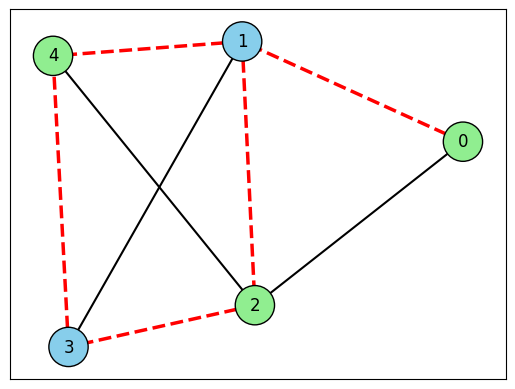

In [22]:
partition = compute_partition_from_probabilities(nodes, edges, state_vectors)
partition_cut_size = cut_size(edges, partition)
print(f"Partition {partition} has cut size {partition_cut_size}")

show_graph_partition(nodes, edges, partition)

Average cut size 4.000109846877242 for gamma = [0.39269908169872414] and beta = [1.0471975511965976]


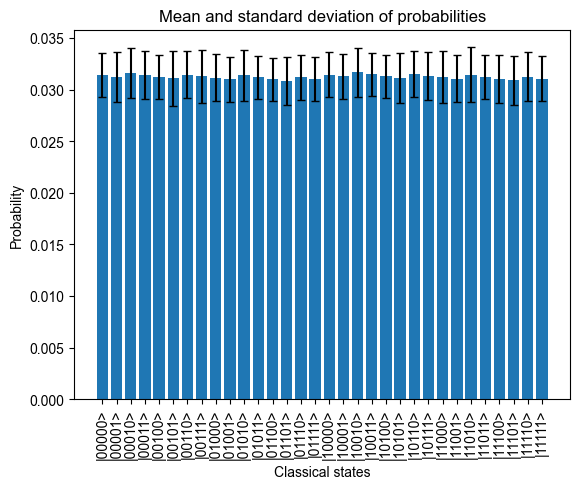

In [44]:
circuit = qaoa_circuit([], [], nodes, edges, 0, noise_factor=1)
state_vectors = execute_circuit(circuit, 100)
plot_probability_distribution_noise(state_vectors)
average_cut_size = compute_average_cut_size_from_probabities(nodes, edges, state_vectors)
print(f"Average cut size {average_cut_size} for gamma = {gamma} and beta = {beta}")